# Perform regression on a sample set using the binned power feature. 

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
plt.style.use('seaborn-notebook')
from utils import eegml_data_load, generate_features
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve, roc_auc_score
%matplotlib inline

## Make a dataframe of file meta data

In [160]:
files_df = eegml_data_load.create_files_df()
files_df.head()

,dir_name,file_name,path,patient,preictal,train,file_id
0,test_1_new,new_1_1.mat,test_1_new/new_1_1.mat,1,-1,0,0
1,test_1_new,new_1_10.mat,test_1_new/new_1_10.mat,1,-1,0,1
2,test_1_new,new_1_100.mat,test_1_new/new_1_100.mat,1,-1,0,2
3,test_1_new,new_1_101.mat,test_1_new/new_1_101.mat,1,-1,0,3
4,test_1_new,new_1_102.mat,test_1_new/new_1_102.mat,1,-1,0,4


## Compute the binned power features. 

In [161]:
%%time

# Create sample set for feature creation.
num_files_cat = 50 # number of test files per category (inter,pre,test)
inter_exs = files_df[files_df['preictal']==0].iloc[:num_files_cat,:]
pre_exs = files_df[files_df['preictal']==1].iloc[:num_files_cat,:]
sample_set = pd.concat([inter_exs, pre_exs])

bin_size = 200 # number of bins to average over
    
avg_bin_norm_power_mat = []
for i,file in sample_set.iterrows():
    print(str(i)+str(" "), end="")
    
    # Normalize and bin power spectra.
    avg_bin_norm_power = generate_features.norm_bin_and_avg_power_spectra(file, bin_size)
    
    # Concatenate result.
    avg_bin_norm_power_mat.append(avg_bin_norm_power)

1908 1909 1911 1912 1913 1914 1915 1916 1918 1919 1920 1921 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1959 1960 1961 1962 1963 1910 1917 1922 1934 1946 1958 1970 1982 1994 2005 2007 2009 2014 2025 2027 2029 2031 2033 2035 2037 2039 2041 2043 2045 2047 2049 2051 2053 2055 2056 2057 2058 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2072 2073 2074 2075 2076 2077 2078 CPU times: user 657 ms, sys: 44.3 ms, total: 702 ms
Wall time: 1.52 s


In [162]:
# Assign feats to sample data frame.
num_feats = len(avg_bin_norm_power_mat[0])
col_names = ['pib_'+str(i) for i in range(num_feats)]
feats = pd.DataFrame(avg_bin_norm_power_mat, columns = col_names)
feats['file_id'] = sample_set['file_id'].values
sample_set_feats = sample_set.merge(feats,how='left')
sample_set_feats.head()

,dir_name,file_name,path,patient,preictal,train,file_id,pib_0,pib_1,pib_2,...,pib_590,pib_591,pib_592,pib_593,pib_594,pib_595,pib_596,pib_597,pib_598,pib_599
0,train_1,1_1009_0.mat,train_1/1_1009_0.mat,1,0,1,1908,0.018110,0.039671,0.042882,...,0.000252,0.000250,0.000259,0.000249,0.000254,0.000250,0.000238,0.000252,0.000240,0.000252
1,train_1,1_100_0.mat,train_1/1_100_0.mat,1,0,1,1909,0.015669,0.019936,0.027271,...,0.000239,0.000252,0.000255,0.000240,0.000244,0.000247,0.000234,0.000252,0.000246,0.000237
2,train_1,1_1010_0.mat,train_1/1_1010_0.mat,1,0,1,1911,0.013686,0.031498,0.036498,...,0.000250,0.000250,0.000241,0.000237,0.000238,0.000233,0.000250,0.000249,0.000235,0.000244
3,train_1,1_1011_0.mat,train_1/1_1011_0.mat,1,0,1,1912,0.014710,0.030240,0.033823,...,0.000260,0.000253,0.000272,0.000272,0.000260,0.000254,0.000253,0.000250,0.000259,0.000252
4,train_1,1_1012_0.mat,train_1/1_1012_0.mat,1,0,1,1913,0.014697,0.028420,0.035914,...,0.000250,0.000267,0.000248,0.000240,0.000251,0.000245,0.000257,0.000259,0.000256,0.000271


## Clean up data for ml.

In [163]:
X = sample_set_feats.loc[:,'pib_0':]
y = sample_set_feats.loc[:,'preictal']
# Split up data for train and cv. 
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.5, random_state=0)
X_train.head()

,pib_0,pib_1,pib_2,pib_3,pib_4,pib_5,pib_6,pib_7,pib_8,pib_9,...,pib_590,pib_591,pib_592,pib_593,pib_594,pib_595,pib_596,pib_597,pib_598,pib_599
91,0.018181,0.016025,0.020369,0.021861,0.021035,0.024477,0.026308,0.027023,0.025179,0.023523,...,0.000292,0.000290,0.000278,0.000308,0.000283,0.000279,0.000283,0.000295,0.000280,0.000289
59,0.020696,0.019692,0.023253,0.025846,0.024369,0.026244,0.028746,0.028255,0.024361,0.022946,...,0.000226,0.000229,0.000234,0.000230,0.000230,0.000224,0.000221,0.000224,0.000228,0.000228
0,0.018110,0.039671,0.042882,0.037684,0.033732,0.031105,0.027885,0.027218,0.025902,0.023802,...,0.000252,0.000250,0.000259,0.000249,0.000254,0.000250,0.000238,0.000252,0.000240,0.000252
34,0.017498,0.015752,0.018535,0.019383,0.020596,0.021970,0.028165,0.033010,0.025635,0.022069,...,0.000303,0.000314,0.000305,0.000303,0.000309,0.000303,0.000318,0.000315,0.000318,0.000312
28,0.020562,0.017934,0.019960,0.020916,0.020994,0.021097,0.024371,0.031739,0.026267,0.022692,...,0.000292,0.000290,0.000291,0.000284,0.000289,0.000271,0.000280,0.000291,0.000297,0.000296


## Create pipeline, fit, and predict.

In [133]:
pipeline = Pipeline(steps=[
    ('imputer', Imputer()),    
    ('classify', SGDClassifier(loss='log'))
])

In [134]:
pipeline.fit(X_train,y_train)
y_pred_cv = pipeline.decision_function(X_cv)
roc_auc_score(y_cv, y_pred_cv)

0.77083333333333326

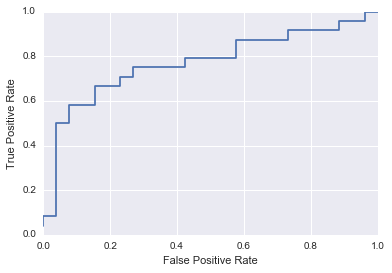

In [135]:
fpr, tpr, thresholds = roc_curve(y_cv,y_pred_cv)
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

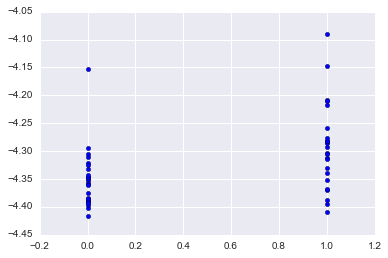

In [146]:
# Make a small df with decision func and actual label.
df = pd.DataFrame({'y_cv':y_cv, 'y_pred_cv':y_pred_cv})
plt.scatter(df['y_cv'],df['y_pred_cv'])
plt.show()